In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mp

from sklearn.model_selection import train_test_split 
from sklearn.model_selection import RandomizedSearchCV

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor

In [2]:
#Getting the well (feature) and streamflow (target) data 
ibound = np.loadtxt('base/ibound_lyr1.txt')            
all_well_loc = np.asarray(np.where(ibound == 1)).T

#Grab the pickles of ReachQ (streamflow) and well heads
ReachQdf = pd.read_pickle('outputs/SS_reachQ1000_test12.pkl')
well_head_df= pd.read_pickle('outputs/heads/WellHead_SS1000test12.pkl')

#Calculating the difference in heads from the wells and in the flows from with the well and without
NoPumpingReachQ = pd.read_pickle('outputs/SS_reachQ1000_test12NoPumping.pkl')
No_pumping_well_head_df = pd.read_pickle('outputs/heads/WellHead_SS1000test12NoPumping.pkl')
#members = np.loadtxt("mf_notebooks/ModflowSfrWellOutput1000test12NoPumping.txt")

diff_head_df = No_pumping_well_head_df - well_head_df#.loc[members.astype('int')]
diff_reachq_df = NoPumpingReachQ - ReachQdf#.loc[members.astype('int')]


In [3]:
## Setting up the head inputs - dropping out the downstream most CH boundary and the river cells 
river_well_loc = np.where(all_well_loc[:,0] == 25)
CHBound_loc = np.where(all_well_loc[:,1] > 47)
drop_locs= np.concatenate((river_well_loc, CHBound_loc), axis = 1)

#currently not dropping any
drop_locs = [[]]

well_head_noRiv = well_head_df.drop(drop_locs[0], axis = 1)
streamflow = ReachQdf.loc[well_head_noRiv.index]


#well_head_noRiv = diff_head_df.drop(drop_locs[0], axis = 1)
#streamflow = diff_reachq_df.loc[well_head_noRiv.index]


### Decision Tree Hyperparameter Tuning 

Prints out the best hyperparameter combo from the search as a dictionary - which we then use in the other notebooks

{'criterion': ['squared_error', 'friedman_mse'], 'max_depth': [4, 5, 6, 7, 8], 'min_samples_split': [2, 5, 10, 15], 'min_samples_leaf': [1, 2, 5, 10], 'max_leaf_nodes': [25, 52, 79, 106, 133, None], 'min_impurity_decrease': [5, 15, 25, 35, 45]}
Number of possible parameter combinations:  4800
Fitting 3 folds for each of 100 candidates, totalling 300 fits
Best DT pars:  {'min_samples_split': 5, 'min_samples_leaf': 2, 'min_impurity_decrease': 25, 'max_leaf_nodes': 52, 'max_depth': 6, 'criterion': 'friedman_mse'}


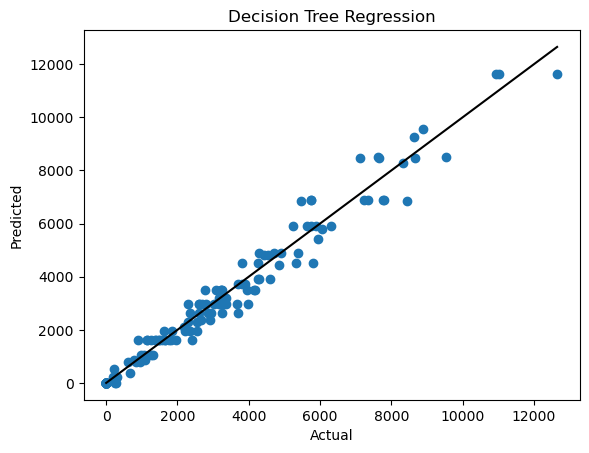

In [4]:
#Finding the hyperparameters

#set this so we can maintain the train test split in the actual run of the model
random_state = 29

#reach number to use 
rn = 32

X_train, X_test, y_train, y_test = train_test_split(well_head_noRiv, streamflow[rn], test_size=0.2, random_state = random_state)

#split quality function
split_criterion = ['squared_error', 'friedman_mse']

#Number of features to consider at every split
max_features = [1.0]

# Maximum number of levels in tree
max_depth = [int(x) for x in range(4,9)] #14 was the max depth, 3 or greater is recommened, 8 seems high enough 
#max_depth.append(None)

# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10, 15]

# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 5, 10]

#maximum 
maxSqrt = int(np.max(y_train)**(1/2))
max_leaf_nodes = [int(x) for x in range(25,maxSqrt,int(maxSqrt/5))]
max_leaf_nodes.append(None)

#min weight fraction leaf - need to look into this one 
#min_weight_fraction_leaf = [0.0]

min_imp_decrease = [int(x) for x in range(5,55,10)]
#min_imp_decrease.append(0)
#cost complexcity prunning 
ccp_alpha = [0.0]

splitter = ['best']
# Create the random grid
random_grid = {#'n_estimators': n_estimators,
                'criterion' : split_criterion,
               #'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
              # 'min_weight_fraction_leaf': min_weight_fraction_leaf,
                'max_leaf_nodes': max_leaf_nodes,
                'min_impurity_decrease':min_imp_decrease}
                #'splitter': splitter}
print(random_grid)

#looking at how many possible parameter combinations there are 
num_par_combos = 1

for i in random_grid.keys():
    num_par_combos *= len(random_grid[i])
print("Number of possible parameter combinations: ", num_par_combos )  

# Use the random grid to search for best hyperparameters
# First create the base model to tune
dtr = DecisionTreeRegressor()

# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
dtr_random = RandomizedSearchCV(estimator = dtr, scoring = 'neg_root_mean_squared_error',param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=29, n_jobs = -1)

# Fit the random search model
dtr_random.fit(X_train, y_train)

best_pars_dt = dtr_random.best_params_
print("Best DT pars: ", best_pars_dt) # This is the most important part

best_random = dtr_random.best_estimator_
y_pred = best_random.predict(X_test)
#well head Tree NSE

#label='Prediction to Test Values for Hyperparameter Tuned Tree'
plt.scatter(y_test, y_pred)  
outmax = np.max(y_test)
plt.plot([0, outmax], [0, outmax], color='k', linestyle='-')
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Decision Tree Regression")
# plt.xlim(60,100)
# plt.ylim(60,100)
#plt.legend()
plt.show()

# _, ax = plt.subplots(figsize=(25, 25))
# _ = plot_tree(best_random, ax=ax)#, feature_names=col_names)

### Gradient Boosting Hyperparameters

In [4]:
new_zone_q = ReachQdf.loc[well_head_noRiv.index]
rn =32
print(GradientBoostingRegressor().get_params().keys())
#choosing one well and finding the hyperparameters that best work for it 
rand_reach = np.random.randint(low=1,high=48)
#print(rand_well)
X_train, X_test, y_train, y_test = train_test_split(well_head_noRiv, streamflow[rn], test_size=0.2,random_state=29)
loss = ['squared_error', 'absolute_error']#, 'huber', 'quantile']
n_estimators = [int(x) for x in range(10,50,10)] #this was found by looking at oob predictions - actually could have been lower than this
subsample = [0.5,0.75,1.0]             
#split quality function
split_criterion = ['squared_error', 'friedman_mse']
splitter = ['best']
#Number of features to consider at every split
max_features = [1.0]#, 'sqrt','log2']
# Maximum number of levels in tree
max_depth = [int(x) for x in range(4,9)] #14 was the max depth, 3 is recommened, 10 seems high enough 
#max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 10, 25]
# Minimum number of samples required at each leaf node
min_samples_leaf = [2, 5, 10]
#maximum 
maxSqrt = int(np.max(y_train)**(1/2))
max_leaf_nodes = [int(x) for x in range(50,maxSqrt,int(maxSqrt/4))]
max_leaf_nodes.append(None)
max_leaf_nodes = [50,maxSqrt,None]
#min weight fraction leaf - need to look into this one 
#min_weight_fraction_leaf = [0.0]
learning_rate = [0.01,0.1,0.5]
min_imp_decrease = [int(x) for x in range(50,125,25)]
#min_imp_decrease.append(0)
#cost complexcity prunning 
ccp_alpha = [0.0]

# Create the random grid
random_grid = {#'n_estimators': n_estimators,
                'loss' : loss,
               # 'subsample':subsample,
                'n_estimators':n_estimators,
                'criterion' : split_criterion,
              # 'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
              # 'min_weight_fraction_leaf': min_weight_fraction_leaf,
               # 'learning_rate': learning_rate,
                'max_leaf_nodes': max_leaf_nodes,
                'min_impurity_decrease':min_imp_decrease}
print(random_grid)
#looking at how many possible parameter combinations there are 
num_par_combos = 1

for i in random_grid.keys():
    num_par_combos *= len(random_grid[i])
print("Number of possible parameter combinations: ", num_par_combos )  



dict_keys(['alpha', 'ccp_alpha', 'criterion', 'init', 'learning_rate', 'loss', 'max_depth', 'max_features', 'max_leaf_nodes', 'min_impurity_decrease', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'n_estimators', 'n_iter_no_change', 'random_state', 'subsample', 'tol', 'validation_fraction', 'verbose', 'warm_start'])
{'loss': ['squared_error', 'absolute_error'], 'n_estimators': [10, 20, 30, 40], 'criterion': ['squared_error', 'friedman_mse'], 'max_depth': [4, 5, 6, 7, 8], 'min_samples_split': [2, 10, 25], 'min_samples_leaf': [2, 5, 10], 'max_leaf_nodes': [50, 136, None], 'min_impurity_decrease': [50, 75, 100]}
Number of possible parameter combinations:  6480


In [5]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
xgr = GradientBoostingRegressor()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
xgr_random = RandomizedSearchCV(estimator = xgr, scoring = 'neg_root_mean_squared_error',param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
xgr_random.fit(X_train, y_train)
best_pars_gr = xgr_random.best_params_
print(best_pars_gr)

best_random_gr = xgr_random.best_estimator_

Fitting 3 folds for each of 100 candidates, totalling 300 fits
{'n_estimators': 40, 'min_samples_split': 25, 'min_samples_leaf': 2, 'min_impurity_decrease': 100, 'max_leaf_nodes': 136, 'max_depth': 8, 'loss': 'squared_error', 'criterion': 'squared_error'}


### Random Forest Hyperparameter tuning

In [8]:
from sklearn.ensemble import RandomForestRegressor
rn = 32
random_state = 29
new_zone_q = ReachQdf.loc[well_head_noRiv.index]

print(RandomForestRegressor().get_params().keys())

X_train, X_test, y_train, y_test = train_test_split(well_head_noRiv, streamflow[rn], test_size=0.2, random_state = random_state)
n_estimators = [int(x) for x in range(10,50,10)] #this was found by looking at oob predictions - actually could have been lower than this

max_sample = [0.3,0.5,0.7] #leaving this at None for now - that way every tree sees more samples            
#split quality function
split_criterion = ['squared_error', 'friedman_mse']
splitter = ['best']
bootstrap = ['True']
#Number of features to consider at every split
max_features = [1.0]
# Minimum number of samples required to split a node
min_samples_split = [2, 10, 25]
# Minimum number of samples required at each leaf node
min_samples_leaf = [2, 5, 10]
#maximum 
maxSqrt = int(np.max(y_train)**(1/2))
max_leaf_nodes = [50,maxSqrt,None]

min_imp_decrease = [int(x) for x in range(50,125,25)]
#cost complexity prunning 
ccp_alpha = [0.0]

# Create the random grid
random_grid = {#'n_estimators': n_estimators,
                #'bootstrap' : bootstrap,
                'max_samples':max_sample,
                'n_estimators':n_estimators,
                'criterion' : split_criterion,
               #'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
              # 'min_weight_fraction_leaf': min_weight_fraction_leaf,
                'max_leaf_nodes': max_leaf_nodes,
                'min_impurity_decrease': min_imp_decrease}
print(random_grid)

#looking at how many possible parameter combinations there are 
num_par_combos = 1

for i in random_grid.keys():
    num_par_combos *= len(random_grid[i])
    
print("Number of possible parameter combinations: ", num_par_combos ) 


dict_keys(['bootstrap', 'ccp_alpha', 'criterion', 'max_depth', 'max_features', 'max_leaf_nodes', 'max_samples', 'min_impurity_decrease', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'n_estimators', 'n_jobs', 'oob_score', 'random_state', 'verbose', 'warm_start'])
{'max_samples': [0.3, 0.5, 0.7], 'n_estimators': [10, 20, 30, 40], 'criterion': ['squared_error', 'friedman_mse'], 'max_depth': [4, 5, 6, 7, 8], 'min_samples_split': [2, 10, 25], 'min_samples_leaf': [2, 5, 10], 'max_leaf_nodes': [50, 136, None], 'min_impurity_decrease': [50, 75, 100]}
Number of possible parameter combinations:  9720


In [9]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rfr = RandomForestRegressor()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rfr_random = RandomizedSearchCV(estimator = rfr, scoring = 'neg_root_mean_squared_error',param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rfr_random.fit(X_train, y_train)
best_pars_rf = rfr_random.best_params_
print(best_pars_rf)

#from sklearn.tree import plot_tree


best_random_rf = rfr_random.best_estimator_
y_pred = best_random_rf.predict(X_test)

#_, ax = plt.subplots(figsize=(25, 25))
#_ = plot_tree(best_random, ax=ax)#, feature_names=col_names)

Fitting 3 folds for each of 100 candidates, totalling 300 fits
{'n_estimators': 30, 'min_samples_split': 2, 'min_samples_leaf': 2, 'min_impurity_decrease': 75, 'max_samples': 0.7, 'max_leaf_nodes': None, 'max_depth': 6, 'criterion': 'squared_error'}
